# Livrable 2 : Traitement d'images
|Erwan Martin|Thibaut Liger-Hellard|Arnaud Maturel|Guillaume Le Cocguen|Victorien Goudeau|
|------------|---------------------|--------------|--------------------|-----------------|

# **Contexte**:
L'entreprise TouNum, spécialisée dans la numérisation de documents, collabore avec des spécialistes en Data Science de CESI pour développer une solution de Machine Learning capable de générer automatiquement des légendes pour les images numérisées. Ce projet vise à enrichir leur offre de services en répondant aux besoins de clients ayant d'importantes quantités de données à classer. Le défi inclut le nettoyage des images de qualité variable et la distinction entre photos et autres types d'images avant l'analyse. L'approche utilisera des technologies avancées telles que les réseaux de neurones convolutifs (CNN) et récurrents (RNN), en s'appuyant sur Python et des librairies spécialisées. Un prototype est attendu dans cinq semaines, suivi d'une présentation détaillée et d'une discussion sur l'intégration et la maintenance de la solution.

# **Objectif**:

L'objectif de ce projet est de développer un autoencodeur qui servira à améliorer la qualité des images qui entreront dans notre algorithme.
!!!!!!!!!!!!!!!!!!!!!à voir!!!!!!!!!!!!!! Pour l'entraîner, un dataset de photos nous est fourni. Nous allons bruiter chacune d'elles et entraîner un réseau de neurones convolutionnels pour les débruiter au mieux, l'objectif étant de comparer le résultat à l'image de base, non bruitée.

# **Données**:

!!!!!!!!!!!!!!!!!!!!!!!! à voir !!!!!!!!!!!!!!!!! Notre jeu de données contient plusieurs milliers d'images de différentes tailles et qualités. Elles seront toutes aléatoirement plus ou moins bruitées avant d'entraîner notre modèle. Pas besoin d'étiquettage dans notre cas, on regardera les différences entre l'image d'entrée non bruitée et l'image de sortie.

# **Défis techniques**:

- Qualité des images: Les images sont de qualité variable, ce qui peut affecter les performances du modèle.

- Autoencodeur : Le modèle doit être capable d'améliorer la qualité de différents types de photographies tout en gardant les couleurs d'origine et les éléments importants distinguables.

- Évaluation du modèle: Le modèle sera évalué sur un ensemble de données de test distinct pour mesurer sa précision et sa perte. 
!!!!!!!!!!!!!!!est-ce qu'on a un autre truc de test après la val ????!!!!!!!!!!!!!!!!!!!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import sklearn
import sklearn.model_selection
import tensorflow as tf
import tensorboard
import cv2
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=9144)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# **Récupération du dataset, séparation en jeux d'entraînement, de validation et de test**

Toutes les photographies du dataset sont dans un même dossier. Nous les récupérons et les séparons en :
- un jeu d'entraînement (70% du dataset) sur lequel le modèle apprend.
- un jeu de validation (10% du dataset) sur lequel l'apprentissage est testé à chaque itération.
- un jeu de test (20% du dataset) sur lequel on conduit nos essais, une fois le modèle terminé.

In [3]:
import os
from sklearn.model_selection import train_test_split

def split_data(image_folder, train_size=0.7, test_size=0.2):
    
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    
    train_files, val_test_files = train_test_split(image_files, train_size=train_size, random_state=42)
    
    val_size = test_size / (1 - train_size)  # Calcul pour garder la proportion correcte pour le test
    val_files, test_files = train_test_split(val_test_files, test_size=val_size, random_state=42)
    
    return train_files, val_files, test_files


filePath = open('../data/path.txt', "r")
datapath = filePath.read()
print(datapath)

image_folder = datapath+'/Photo'
train_files, val_files, test_files = split_data(image_folder)


D:\CESI\A5\datascience\Projet\data


# **Bruitage des images**

La fonction `image_noise_generator` va recevoir les photographies en entrée, et leur appliquer un bruitage aléatoire puis les renvoyer en sortie.

Ici l'objectif est de produire des données d'entrées dégradées à notre algorithme afin qu'il puisse au mieux en améliorer la qualité. Dans un contexte plus global cela permet de limiter l'impact des images de mauvaise qualité sur des opérations telles que de la classification.

In [4]:
def image_noise_generator(image_files, batch_size, noise_factor=0.5, img_size=(400, 400)):
    while True:
        image_files = shuffle(image_files)
        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]
            batch_images = []
            batch_noisy_images = []
            for file in batch_files:
                img = cv2.imread(file)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    img = img.astype('float32') / 255.0
                    noisy_img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
                    noisy_img = np.clip(noisy_img, 0, 1)
                    batch_images.append(img)
                    batch_noisy_images.append(noisy_img)
            yield np.array(batch_noisy_images), np.array(batch_images)


# **Débruitage des images**

!!!!!!!! à relire pour voir si je raconte pas nimp !!!!!!!!

Après avoir bruités les images à des fins de test sur des données d'entrées dégradées, nous voulons apporter une solution à ce problème potentiel. Pour ce faire nous nous mettons en place un fonction qui débruittera les images afin de les faire se rapprocher de ce qu'elles représentaient à l'origine.

L'utilisation de convolution et de max pooling permettra de faire ressortir les caractéristiques principales de l'image et de reconstruire une image présentant des caractéristiques principales similaires à celles qu'auraient dûes être celles de l'image d'entrée non bruitée

In [5]:
def denoises_model():
    inputs = tf.keras.Input(shape=(400, 400, 3))
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(inputs)
    xp1 = tf.keras.layers.MaxPool2D(2,2)(x)
    x1 = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(xp1)
    xp2 = tf.keras.layers.MaxPool2D(2,2)(x1)
    x2 = tf.keras.layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(xp2)
    xp3 = tf.keras.layers.MaxPool2D(2,2)(x2)
    x3 = tf.keras.layers.Conv2D(256, 3, activation="relu", strides=1, padding="same")(xp3)
    xp4 = tf.keras.layers.MaxPool2D(2,2)(x3)
    encodeur = tf.keras.Model(inputs, xp4, name="encoded")

    decoder_input = tf.keras.Input(shape=(25, 25, 256))
    z = tf.keras.layers.Conv2DTranspose(64, 5, activation="relu", strides=1, padding="same")(decoder_input)
    zp1 = tf.keras.layers.UpSampling2D((2,2))(z)
    z1 = tf.keras.layers.Conv2DTranspose(32, 5, activation="relu", strides=1, padding="same")(zp1)
    zp2 = tf.keras.layers.UpSampling2D((2,2))(z1)
    z2 = tf.keras.layers.Conv2DTranspose(8, 5, activation="relu", strides=1, padding="same")(zp2)
    zp3 = tf.keras.layers.UpSampling2D((2,2))(z2)
    z3 = tf.keras.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(zp3)
    outputs = tf.keras.layers.UpSampling2D((2,2))(z3)
    decodeur = tf.keras.Model(decoder_input, outputs, name="decoded")

    auto_input = tf.keras.Input(shape=(400, 400, 3))
    encoded = encodeur(auto_input)
    decoded = decodeur(encoded)
    auto_encodeur = tf.keras.Model(auto_input, decoded, name="auto_encodeur")
    auto_encodeur.compile(optimizer='adam', loss=['mean_squared_error', 'binary_crossentropy'])

    return auto_encodeur

auto_encodeur_model = denoises_model()
auto_encodeur_model.summary()


Model: "auto_encodeur"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 encoded (Functional)        (None, 25, 25, 256)       388416    
                                                                 
 decoded (Functional)        (None, 400, 400, 3)       467523    
                                                                 
Total params: 855,939
Trainable params: 855,939
Non-trainable params: 0
_________________________________________________________________


In [6]:
batch_size = 32

train_generator = image_noise_generator(train_files, batch_size)
val_generator = image_noise_generator(val_files, batch_size)
test_generator = image_noise_generator(test_files, batch_size)

steps_per_epoch = len(train_files) // batch_size
validation_steps = len(val_files) // batch_size
test_steps = len(test_files) // batch_size


# **Optimisation des performances**

!!!!!!!! à relire pour voir si je raconte pas nimp !!!!!!!!

Pour éviter les écueils lors de l'entrainement de notre algorihtme tels que l'overfitting. Nous utilisons une fonction qui surveillera notre valeur de perte (loss) ainsi à chaque époch nous mettrons à jour la valeur minimal de la loss, si cette dernière cesse de diminuer après plusieurs époch nous considérons que les poids utilisés sont les plus optimaux et donc que nous pouvons arréter notre entrainement.

In [7]:
class EarlyStoppingAtMinLossAndSave(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. After this
        number of no improvement, training stops.
    """

    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        print("The average loss for epoch {} is {:7.2f} ".format(epoch, logs["loss"])) #print the loss

        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
            self.model.save_weights('./models/last_training_best_weights')
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


#TENSORBOARD
time = datetime.now()
foldername = f"./tensorboard/{time.day}_{time.month}_{time.year}_{time.hour}h{time.minute}"

tensorflowCallback = tf.keras.callbacks.TensorBoard(
    log_dir=foldername,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [8]:
history = auto_encodeur_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[EarlyStoppingAtMinLossAndSave(patience=2), tensorflowCallback]
)

Epoch 1/10
218/218 [==============================] - 196s 858ms/step - loss: 0.0298 - val_loss: 0.0147
Epoch 2/10
218/218 [==============================] - 154s 698ms/step - loss: 0.0126 - val_loss: 0.0114
Epoch 3/10
218/218 [==============================] - 152s 699ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 4/10
218/218 [==============================] - 174s 802ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 5/10
218/218 [==============================] - 171s 786ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 6/10
218/218 [==============================] - 173s 798ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 7/10
218/218 [==============================] - 170s 780ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 8/10
218/218 [==============================] - 170s 783ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 9/10
218/218 [==============================] - 171s 786ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 10/10
218/218 [==============================] - 169s 776m

In [9]:
test_loss = auto_encodeur_model.evaluate(test_generator, steps=test_steps)
print('Test Loss:', test_loss)

62/62 [==============================] - 66s 1s/step - loss: 0.0081
Test Loss: 0.008109410293400288


In [10]:
import random

def prepare_example(number, folder, model, noise_factor=0.5, img_size = (400,400)):
    image_files = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    random.shuffle(image_files)
    image_files = image_files[:number]

    original_images = []
    noised_images = []
    denoised_images = []

    for file in image_files:
        img = cv2.imread(file)
        if img is not None:
            img_correct_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_correct_color, img_size)
            img_normalized = img_resized.astype('float32') / 255.0
            img_batch = np.expand_dims(img_normalized, axis=0)
            noisy_img = img_batch + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img_batch.shape)
            noisy_img = np.clip(noisy_img, 0, 1)


            predicted = model.predict(noisy_img)
            predicted_image = predicted.squeeze()

            # print(f"original : {img_resized.shape}")
            # print(f"noised : {(noisy_img[0,:,:,:]*255).astype('int8')}")

            original_images.append(img_resized)
            noised_images.append(noisy_img[0,:,:,:])
            denoised_images.append(predicted_image)

    return original_images, noised_images, denoised_images

def display_images(original_images, noised_images, denoised_images):
    plt.figure(figsize=(30, 10))
    
    num_images = len(original_images)
    for i in range(num_images):
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis("off")


        ax = plt.subplot(3, num_images, i + 1+ num_images)
        plt.imshow(noised_images[i])
        plt.title("noised")
        plt.axis("off")

        ax = plt.subplot(3, num_images, i + 1 + 2*num_images)
        plt.imshow(denoised_images[i])
        plt.title("Denoised")
        plt.axis("off")
    
    plt.show()

1/1 [==============================] - 0s 15ms/step


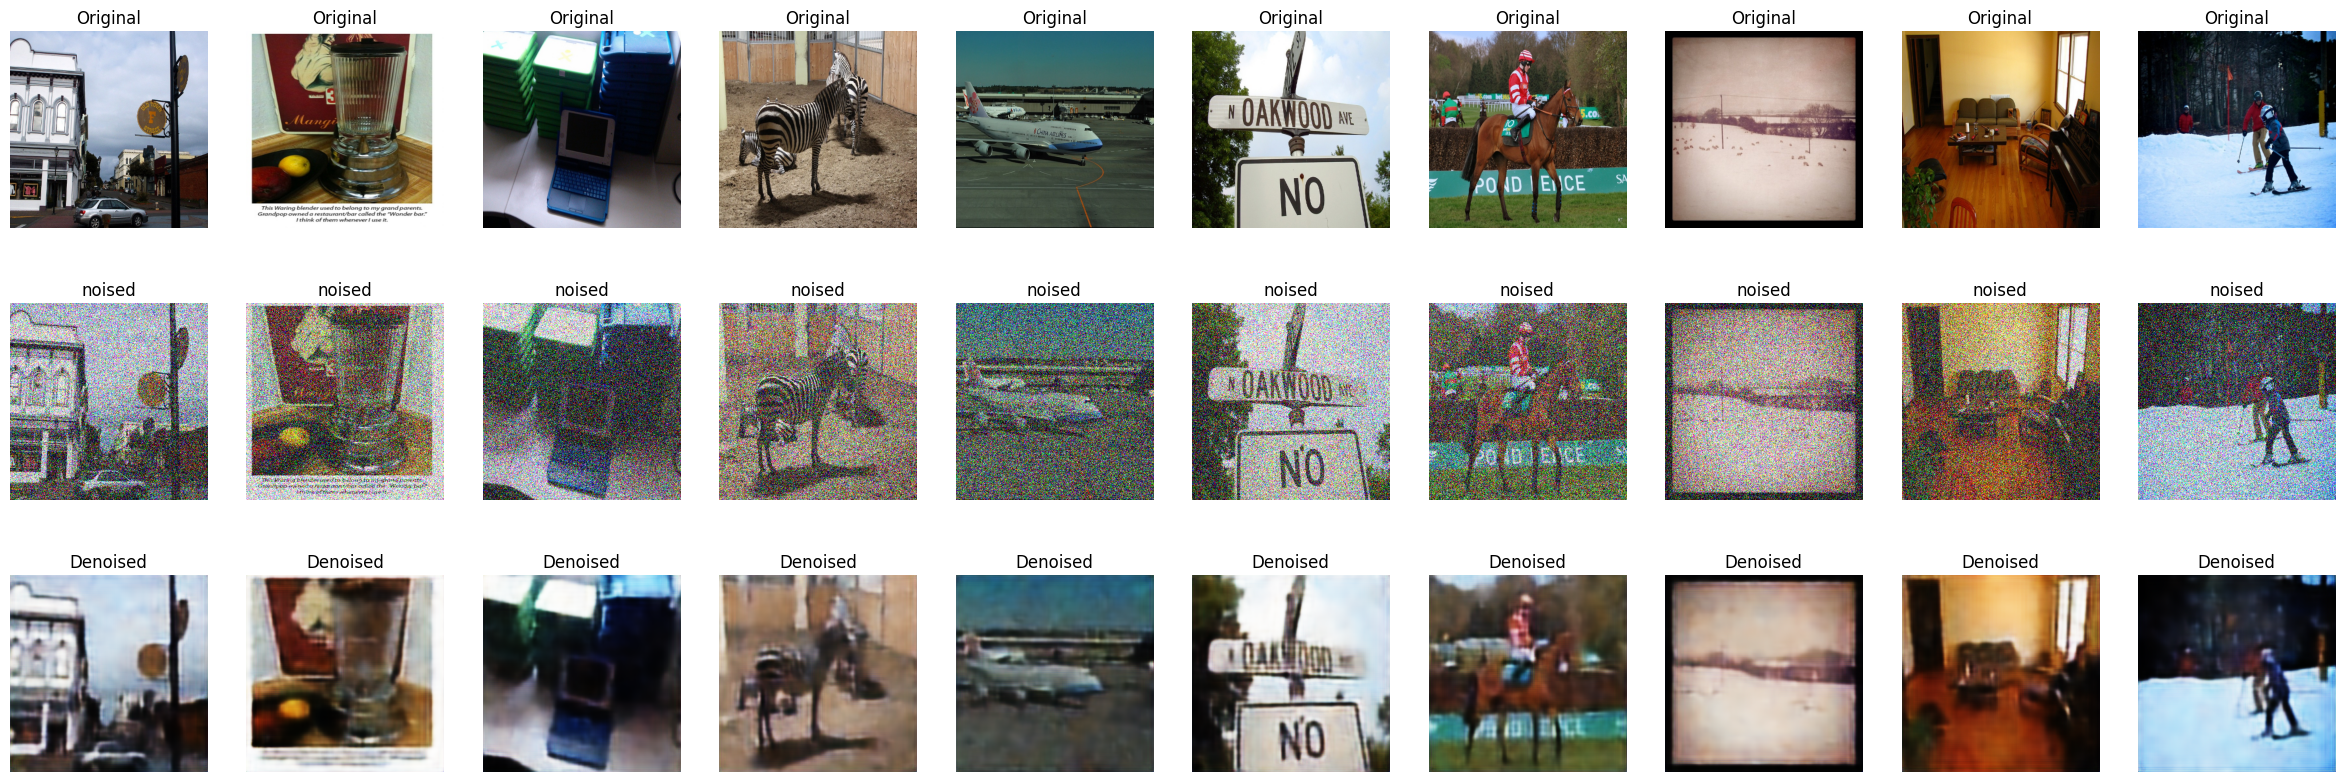

In [11]:
test_image_folder = datapath+'\Dataset_L2'

original_imgs, noised_images, denoised_imgs = prepare_example(10, test_image_folder, auto_encodeur_model, noise_factor=0.5)

display_images(original_imgs, noised_images, denoised_imgs)